In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [25]:
pip install fairlearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.experimental import enable_halving_search_cv  # noqa
# from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold, cross_val_score,train_test_split, GridSearchCV, HalvingGridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    true_positive_rate,
    false_positive_rate,
    false_negative_rate,
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import EqualizedOdds
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import warnings


In [27]:
df = pd.read_csv("merged_data1.csv")

df.drop(columns='ID', inplace=True)

# Select the columns where you want to remove outliers
columns_to_filter = ['AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN']

# Calculate upper bounds for each selected column
upper_bounds = df[columns_to_filter].quantile(0.98)

# Define the boundaries for outlier removal
upper_bound_limits = upper_bounds 

# Filter out the rows containing outliers in any of the selected columns
df = df[~(df[columns_to_filter] > upper_bound_limits).any(axis=1)]

sensitive_features= 'CODE_GENDER'
A = df[sensitive_features]
A.head()

X = df.drop(['target', 'CODE_GENDER'], axis=1)
y = df['target']

In [28]:
def resample_training_data(X_train, Y_train, A_train, random_state=66):
    
    np.random.seed(random_state)
    negative_ids = Y_train[Y_train == 0].index
    positive_ids = Y_train[Y_train == 1].index
    balanced_ids = positive_ids.union(
        np.random.choice(a=negative_ids, size=len(positive_ids), replace=False)
    )

    X_train = X_train.loc[balanced_ids, :]
    Y_train = Y_train.loc[balanced_ids]
    A_train = A_train.loc[balanced_ids]
    return X_train, Y_train, A_train

In [29]:
def balance_classes_upsample(df_train, target, feature, random_state=123):
    # Split the dataset based on the target variable
    df_class_0 = df_train[df_train[target] == 0]
    df_class_1 = df_train[df_train[target] == 1]

    # Calculate the number of samples for the imbalanced feature within each class
    N_gender_1_class_0 = len(df_class_0[df_class_0[feature] == 1])
    N_gender_0_class_0 = len(df_class_0[df_class_0[feature] == 0])
    N_gender_1_class_1 = len(df_class_1[df_class_1[feature] == 1])
    N_gender_0_class_1 = len(df_class_1[df_class_1[feature] == 0])

    # Determine the majority class for each gender within each class
    target_count = max(N_gender_1_class_0, N_gender_0_class_0, N_gender_1_class_1, N_gender_0_class_1)

    # Resample the imbalanced feature within each class
    # For class 1, CODE_GENDER = 1
    minority_class_1 = df_class_1[df_class_1[feature] == 1]
    oversampled_minority_1 = resample(minority_class_1, replace=True,n_samples=target_count,random_state=random_state)
    # For class 1, CODE_GENDER = 0
    majority_class_1 = df_class_1[df_class_1[feature] == 0]
    oversampled_majority_1 = resample(majority_class_1, replace=True,n_samples=target_count,random_state=random_state)
    balanced_class_1 = pd.concat([oversampled_minority_1, oversampled_majority_1])

    # For class 0, CODE_GENDER = 1
    minority_class_0 = df_class_0[df_class_0[feature] == 1]
    oversampled_minority_0 = resample(minority_class_0,replace=True,n_samples=target_count,random_state=random_state)
    # For class 0, CODE_GENDER = 0
    majority_class_0 = df_class_0[df_class_0[feature] == 0]
    oversampled_majority_0 = resample(majority_class_0, replace=True,n_samples=target_count,random_state=random_state)
    balanced_class_0 = pd.concat([oversampled_minority_0, oversampled_majority_0])

    # Combine the balanced classes into a single DataFrame
    balanced_df = pd.concat([balanced_class_0, balanced_class_1])

    return balanced_df

In [30]:
def balance_classes_downsample(df_train, target, feature, random_state=123):
    # Split the dataset based on the target variable
    df_class_0 = df_train[df_train[target] == 0]
    df_class_1 = df_train[df_train[target] == 1]

    # Calculate the number of samples for the imbalanced feature within each class
    N_gender_1_class_0 = len(df_class_0[df_class_0[feature] == 1])
    N_gender_0_class_0 = len(df_class_0[df_class_0[feature] == 0])
    N_gender_1_class_1 = len(df_class_1[df_class_1[feature] == 1])
    N_gender_0_class_1 = len(df_class_1[df_class_1[feature] == 0])

    # Determine the minority class size for each gender within each class
    target_count_class_0 = min(N_gender_1_class_0, N_gender_0_class_0)
    target_count_class_1 = min(N_gender_1_class_1, N_gender_0_class_1)

    # Downsample the majority feature within each class
    # For class 1, CODE_GENDER = 0
    majority_class_1 = df_class_1[df_class_1[feature] == 0]
    downsampled_majority_1 = resample(majority_class_1,
                                      replace=False,  # Sample without replacement
                                      n_samples=target_count_class_1,
                                      random_state=random_state)
    # For class 1, CODE_GENDER = 1
    minority_class_1 = df_class_1[df_class_1[feature] == 1]
    downsampled_minority_1 = resample(minority_class_1,
                                      replace=False,
                                      n_samples=target_count_class_1,
                                      random_state=random_state)
    balanced_class_1 = pd.concat([downsampled_minority_1, downsampled_majority_1])

    # For class 0, CODE_GENDER = 0
    majority_class_0 = df_class_0[df_class_0[feature] == 0]
    downsampled_majority_0 = resample(majority_class_0,
                                      replace=False,  # Sample without replacement
                                      n_samples=target_count_class_0,
                                      random_state=random_state)
    # For class 0, CODE_GENDER = 1
    minority_class_0 = df_class_0[df_class_0[feature] == 1]
    downsampled_minority_0 = resample(minority_class_0,
                                      replace=False,
                                      n_samples=target_count_class_0,
                                      random_state=random_state)
    balanced_class_0 = pd.concat([downsampled_minority_0, downsampled_majority_0])

    # Combine the balanced classes into a single DataFrame
    balanced_df = pd.concat([balanced_class_0, balanced_class_1])

    return balanced_df

In [31]:
fairness_metrics = {
    "count": count,
    "balanced_accuracy": balanced_accuracy_score,
    "selection_rate": selection_rate,
    'true_positive_rate': true_positive_rate,
    "false_positive_rate": false_positive_rate,
    "false_negative_rate": false_negative_rate
}

metrics_to_report = [
    "balanced_accuracy",
    "selection_rate",
    'true_positive_rate',
    "false_positive_rate",
    "false_negative_rate",
]

##unmitigated xgb

In [33]:
value_unmitigated = []
value_unmitigated_overall = []

random_states = range(10)

for rs in random_states:

    X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, A, test_size=0.2, random_state=rs, stratify=y)

    X_train_down, y_train_down, A_train_down = resample_training_data(X_train, y_train, A_train)

    pipeline_steps = [
        ('scaler', MinMaxScaler()),
        ('classifier', XGBClassifier())
    ]

    # Create the pipeline
    model_pipeline_xgb = Pipeline(steps=pipeline_steps)

    # Define the parameter grid
    param_grid_xgb = {
        'classifier__n_estimators': np.arange(20, 400, 20),
        'classifier__learning_rate': [0.01, 0.02, 0.05, 0.08, 0.1, 0.15, 0.2],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__max_depth': np.arange(3, 18, 1),
        'classifier__min_child_weight': np.arange(1, 8, 1),
        # 'classifier__eval_metric': ['auc']
    }

    # To let the random search to give the same result each time
    random_search_xgb =RandomizedSearchCV(model_pipeline_xgb, param_grid_xgb, scoring='balanced_accuracy', cv=5, random_state=234).fit(X_train_down, y_train_down)
    best_pipeline_xgb = random_search_xgb.best_estimator_
    y_test_pred_xgb = best_pipeline_xgb.predict(X_test)

    metricframe_unmitigated = MetricFrame(
        metrics=fairness_metrics,
        y_true=y_test,
        y_pred=y_test_pred_xgb,
        sensitive_features=A_test,
    )

    metricframe_unmitigated.overall[metrics_to_report]

    # plt.ioff

    # ax_arr_upsample = metricframe_unmitigated_upsample.by_group[metrics_to_report].plot.bar(
    #     subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
    # )

    # for ax in ax_arr_upsample.flatten():
    #   for bar in ax.patches:
    #     value.append(bar.get_height())
    # Extract metric values by group and append to value list
    overall_metrics = metricframe_unmitigated.overall[metrics_to_report]
    for metric in metrics_to_report:
        overall_value = overall_metrics[metric]
        value_unmitigated_overall.append(overall_value)
        
    # Extract metric values by group and append to value list
    by_group_metrics = metricframe_unmitigated.by_group[metrics_to_report]
    for metric in metrics_to_report:
        for group_value in by_group_metrics[metric]:
            value_unmitigated.append(group_value)

# Print or use the collected values as needed
print("Collected metric values by group:", value_unmitigated)
print("Collected metric values overall:", value_unmitigated_overall)


Collected metric values by group: [0.5956863166953529, 0.5832180485799926, 0.445609756097561, 0.5058886509635975, 0.6160714285714286, 0.6504065040650406, 0.4246987951807229, 0.4839704069050555, 0.38392857142857145, 0.34959349593495936, 0.5884730884730884, 0.5895406579764122, 0.45749086479902557, 0.4562533548040794, 0.6153846153846154, 0.6111111111111112, 0.43843843843843844, 0.43202979515828677, 0.38461538461538464, 0.3888888888888889, 0.5722493240860468, 0.5964247927103127, 0.4572127139364303, 0.5042598509052183, 0.5851063829787234, 0.6741071428571429, 0.44060773480662985, 0.48125755743651755, 0.4148936170212766, 0.32589285714285715, 0.5912859133454873, 0.5778057383466837, 0.41064453125, 0.4946581196581197, 0.5726681127982647, 0.630901287553648, 0.39009628610729025, 0.47528981086028066, 0.42733188720173537, 0.36909871244635195, 0.5995644793232037, 0.587957497048406, 0.46215624239474323, 0.516406670252824, 0.6393805309734514, 0.6694214876033058, 0.44025157232704404, 0.4935064935064935,

Averages: [0.59716227942197, 0.45896447721179634, 0.6306916426512967, 0.4363670838073569, 0.36930835734870315]
Standard Deviations: [0.014054797244677402, 0.014713752259325528, 0.03294043934757295, 0.013931376007059725, 0.03294043934757295]


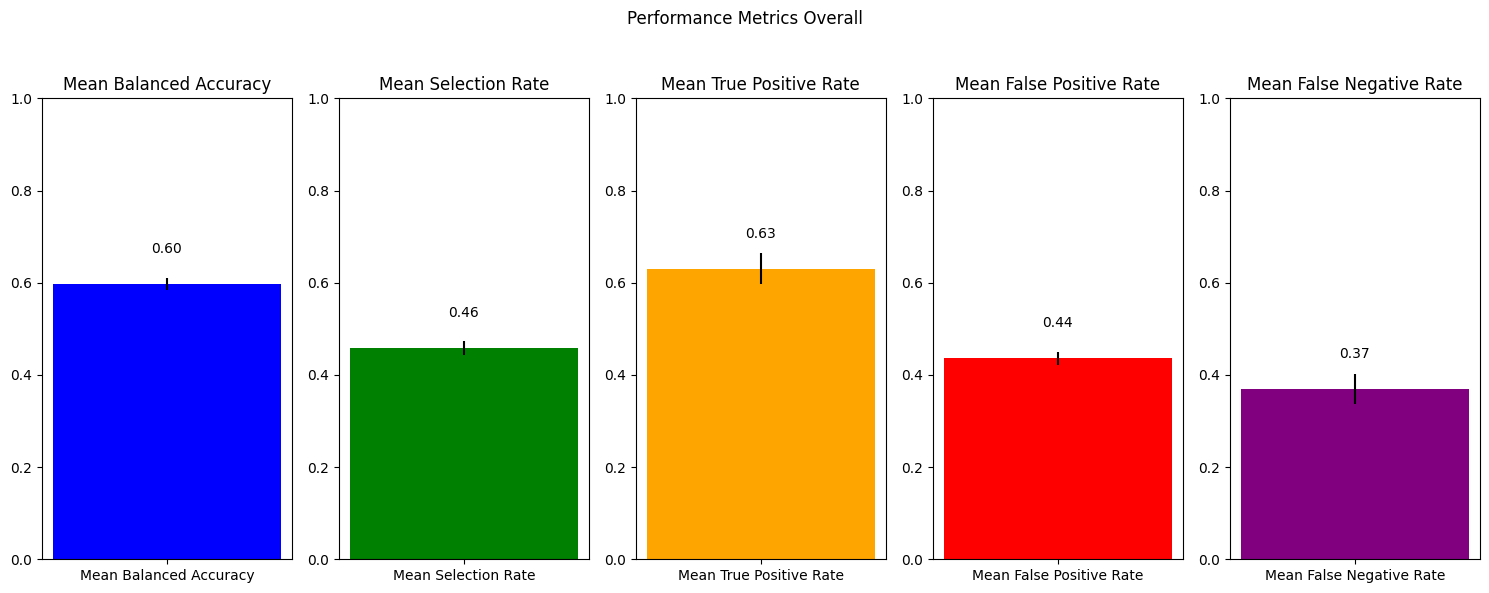

In [39]:
sums = [0] * 5
counts = [0] * 5
values_overall = [[] for _ in range(5)]

for i in range(len(value_unmitigated_overall)):
    group_index = i % 5
    sums[group_index] += value_unmitigated_overall[i]
    counts[group_index] += 1
    values_overall[group_index].append(value_unmitigated_overall[i])

averages = [sums[i] / counts[i] for i in range(5)]

std_devs = [np.std(values_overall[i]) for i in range(5)]

print("Averages:", averages)
print("Standard Deviations:", std_devs)

# # Corresponding labels
# labels = ['Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male']

# Colors for different metrics
colors = ['blue', 'green','orange', 'red','purple']

# Titles for different metric groups
titles = ['Mean Balanced Accuracy', 'Mean Selection Rate', 'Mean True Positive Rate', 'Mean False Positive Rate', 'Mean False Negative Rate' ]

# Create a bar plot
fig, ax_arr = plt.subplots(1, 5, figsize=(15, 6))

# Group data for each subplot
overall_averages = [averages[0], averages[1], averages[2], averages[3], averages[4]]
overall_std_devs = [std_devs[0], std_devs[1], std_devs[2], std_devs[3], std_devs[4]]
# grouped_labels = [labels[:2], labels[2:4], labels[4:6], labels[6:8], labels[8:]]
overall_colors = [colors[0], colors[1], colors[2], colors[3], colors[4]]

for i, ax in enumerate(ax_arr):
    # Plot bars
    bars = ax.bar( x=titles[i], height=overall_averages[i], yerr=overall_std_devs[i],  color=overall_colors[i])

    # Add labels to bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.06, f'{height:.2f}', ha='center', va='bottom')

    # Set the title for each subplot
    ax.set_title(titles[i])

    # Set the y-axis limit
    ax.set_ylim(0, 1)

# Add a main title for the entire figure
fig.suptitle('Performance Metrics Overall')

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Averages: [0.5978786348918338, 0.5931228335078551, 0.4407594122637238, 0.4992946382536852, 0.6148585253199605, 0.6616496329602554, 0.41910125553629285, 0.475403965944545, 0.3851414746800395, 0.3383503670397447]
Standard Deviations: [0.016309649911729833, 0.012270613332303254, 0.0170840958737445, 0.025940112721222153, 0.033994983227098485, 0.03736456002908811, 0.017536108061450575, 0.025095374083953122, 0.03399498322709849, 0.037364560029088105]


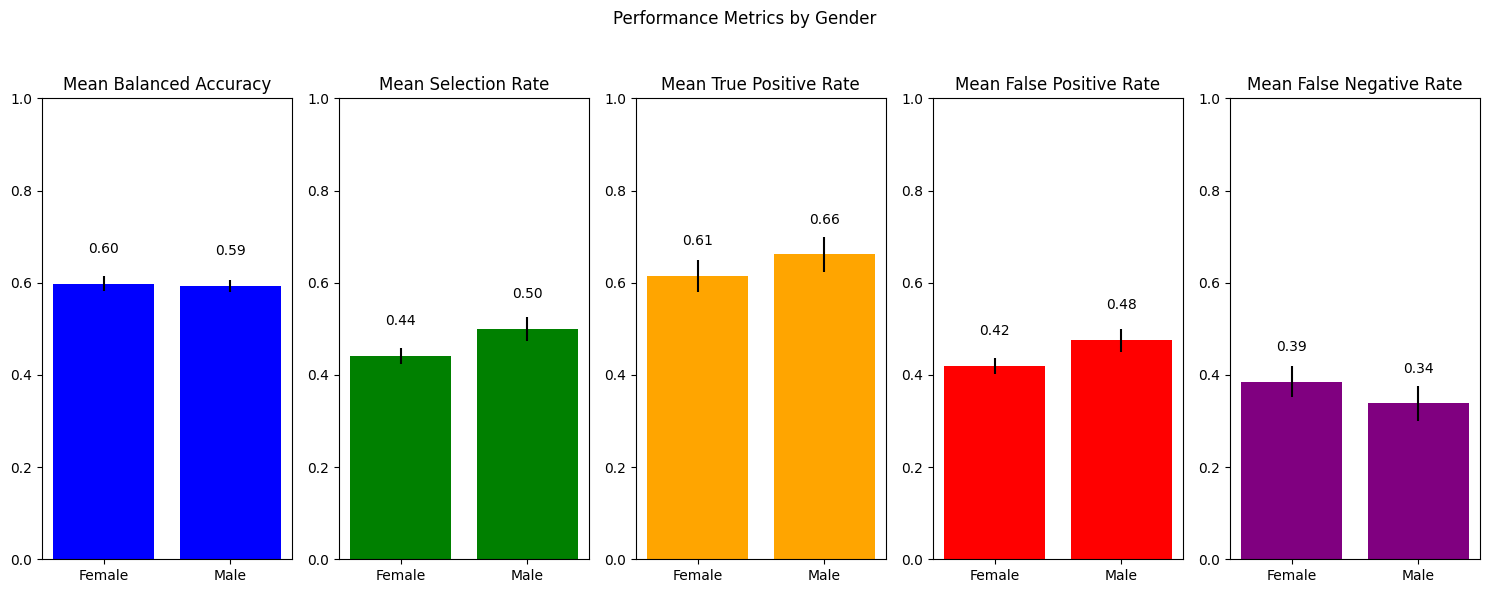

In [12]:
sums = [0] * 10
counts = [0] * 10
values_by_group = [[] for _ in range(10)]

for i in range(len(value_unmitigated)):
    group_index = i % 10
    sums[group_index] += value_unmitigated[i]
    counts[group_index] += 1
    values_by_group[group_index].append(value_unmitigated[i])

averages = [sums[i] / counts[i] for i in range(10)]

std_devs = [np.std(values_by_group[i]) for i in range(10)]

print("Averages:", averages)
print("Standard Deviations:", std_devs)

# Corresponding labels
labels = ['Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male']

# Colors for different metrics
colors = ['blue', 'blue', 'green', 'green', 'orange', 'orange', 'red', 'red', 'purple', 'purple']

# Titles for different metric groups
titles = ['Mean Balanced Accuracy', 'Mean Selection Rate', 'Mean True Positive Rate', 'Mean False Positive Rate', 'Mean False Negative Rate' ]

# Create a bar plot
fig, ax_arr = plt.subplots(1, 5, figsize=(15, 6))

# Group data for each subplot
grouped_averages = [averages[:2], averages[2:4], averages[4:6], averages[6:8], averages[8:]]
grouped_std_devs = [std_devs[:2], std_devs[2:4], std_devs[4:6], std_devs[6:8], std_devs[8:]]
grouped_labels = [labels[:2], labels[2:4], labels[4:6], labels[6:8], labels[8:]]
grouped_colors = [colors[:2], colors[2:4], colors[4:6], colors[6:8], colors[8:]]

for i, ax in enumerate(ax_arr):
    # Plot bars
    bars = ax.bar(grouped_labels[i], grouped_averages[i], yerr=grouped_std_devs[i],  color=grouped_colors[i])

    # Add labels to bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.06, f'{height:.2f}', ha='center', va='bottom')

    # Set the title for each subplot
    ax.set_title(titles[i])

    # Set the y-axis limit
    ax.set_ylim(0, 1)

# Add a main title for the entire figure
fig.suptitle('Performance Metrics by Gender')

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

###upsampling

In [13]:
# random_states = range(2)
# all_data = []

# def generate_ax_arr_upsample():
#     sensitive_features= 'CODE_GENDER'
#     A_train_up = balanced_df[sensitive_features]

#     X_train_up = balanced_df.drop(['target', 'CODE_GENDER'], axis=1)
#     y_train_up = balanced_df['target']

#     pipeline_steps = [('scaler', MinMaxScaler()),('classifier', XGBClassifier())]

#     # Create the pipeline
#     model_pipeline_upsample = Pipeline(steps=pipeline_steps)

#     # Define the parameter grid
#     param_grid_upsample = {
#         'classifier__n_estimators': np.arange(20, 400, 20),
#         'classifier__learning_rate': [0.01, 0.02, 0.05, 0.08, 0.1, 0.15, 0.2],
#         'classifier__subsample': [0.6, 0.8, 1.0],
#         'classifier__max_depth': np.arange(3, 18, 1),
#         'classifier__min_child_weight': np.arange(1, 8, 1),
#         # 'classifier__eval_metric': ['auc']
#     }

#     # To let the random search to give the same result each time
#     random_search_upsample = RandomizedSearchCV(model_pipeline_upsample, param_grid_upsample, scoring='balanced_accuracy', cv=5, random_state=234).fit(X_train_up, y_train_up)
#     best_pipeline_upsample = random_search_upsample.best_estimator_

#     y_test_pred_upsample = best_pipeline_upsample.predict(X_test)

#     metricframe_unmitigated_upsample = MetricFrame(
#         metrics=fairness_metrics,
#         y_true=y_test,
#         y_pred=y_test_pred_upsample,
#         sensitive_features=A_test,
#     )

#     metricframe_unmitigated_upsample.overall[metrics_to_report]

#     ax_arr_upsample = metricframe_unmitigated_upsample.by_group[metrics_to_report].plot.bar(
#         subplots=True, layout=[1, 5], figsize=[12, 4], legend=None, rot=0
#     )
#     fig, ax = plt.subplots()
#     ax.bar(['Female', 'Male'], [np.random.random(), np.random.random()])
#     return ax

# for rs in random_states:

#     X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, A, test_size=0.2, random_state=rs, stratify=y)

#     X_train_down, y_train_down, A_train_down = resample_training_data(X_train, y_train, A_train)

#     df_train =  pd.concat([X_train_down, A_train_down], axis=1)
#     df_train['target'] = y_train_down
#     balanced_df = balance_classes_upsample(df_train, target='target', feature='CODE_GENDER', random_state=123)

#     ax = generate_ax_arr_upsample()
#     data = [bar.get_height() for bar in ax.patches]
#     all_data.append(data)

# mean_data = np.mean(all_data, axis=0)

# # 生成新的图形显示均值
# fig, ax = plt.subplots()
# bars = ax.bar(['Female', 'Male'], mean_data)

# # 在柱子上添加标签
# for bar in bars:
#     value = bar.get_height()
#     text = f'{value:.2f}'
#     ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), text, ha='center', va='bottom')

# # 设置x轴刻度标签
# ax.set_xticks(range(2))
# ax.set_xticklabels(['Female', 'Male'])

# # 显示图形
# plt.tight_layout()
# plt.show()



In [42]:
random_states = range(10)
value=[]
value_overall = []

for rs in random_states:

    X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, A, test_size=0.2, random_state=rs, stratify=y)

    X_train_down, y_train_down, A_train_down = resample_training_data(X_train, y_train, A_train)

    df_train =  pd.concat([X_train_down, A_train_down], axis=1)
    df_train['target'] = y_train_down
    balanced_df = balance_classes_upsample(df_train, target='target', feature='CODE_GENDER', random_state=123)
    sensitive_features= 'CODE_GENDER'
    A_train_up = balanced_df[sensitive_features]

    X_train_up = balanced_df.drop(['target', 'CODE_GENDER'], axis=1)
    y_train_up = balanced_df['target']

    pipeline_steps = [
    ('scaler', MinMaxScaler()),
    ('classifier', XGBClassifier())
    ]

    # Create the pipeline
    model_pipeline_upsample = Pipeline(steps=pipeline_steps)

    # Define the parameter grid
    param_grid_upsample = {
        'classifier__n_estimators': np.arange(20, 400, 20),
        'classifier__learning_rate': [0.01, 0.02, 0.05, 0.08, 0.1, 0.15, 0.2],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__max_depth': np.arange(3, 18, 1),
        'classifier__min_child_weight': np.arange(1, 8, 1),
        # 'classifier__eval_metric': ['auc']
    }

    # To let the random search to give the same result each time
    random_search_upsample = RandomizedSearchCV(model_pipeline_upsample, param_grid_upsample, scoring='balanced_accuracy', cv=5, random_state=234).fit(X_train_up, y_train_up)
    best_pipeline_upsample = random_search_upsample.best_estimator_

    y_test_pred_upsample = best_pipeline_upsample.predict(X_test)

    metricframe_unmitigated_upsample = MetricFrame(
        metrics=fairness_metrics,
        y_true=y_test,
        y_pred=y_test_pred_upsample,
        sensitive_features=A_test,
    )

    metricframe_unmitigated_upsample.overall[metrics_to_report]

    # plt.ioff

    # ax_arr_upsample = metricframe_unmitigated_upsample.by_group[metrics_to_report].plot.bar(
    #     subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
    # )

    # for ax in ax_arr_upsample.flatten():
    #   for bar in ax.patches:
    #     value.append(bar.get_height())
    # Extract metric values by group and append to value list
    overall_metrics = metricframe_unmitigated_upsample.overall[metrics_to_report]
    for metric in metrics_to_report:
        overall_value = overall_metrics[metric]
        value_overall.append(overall_value)

    # Extract metric values by group and append to value list
    by_group_metrics = metricframe_unmitigated_upsample.by_group[metrics_to_report]
    for metric in metrics_to_report:
        for group_value in by_group_metrics[metric]:
            value.append(group_value)

# Print or use the collected values as needed
print("Collected metric values by group:", value)


Collected metric values by group: [0.5838324890470975, 0.6131870720680079, 0.42878048780487804, 0.4416488222698073, 0.578125, 0.6382113821138211, 0.41046002190580505, 0.4118372379778052, 0.421875, 0.3617886178861789, 0.5929164458576224, 0.6459940587035559, 0.42241169305724724, 0.41814278046162107, 0.5882352941176471, 0.6706349206349206, 0.4024024024024024, 0.3786468032278088, 0.4117647058823529, 0.32936507936507936, 0.5951775008816269, 0.5929402746588357, 0.41662591687041567, 0.43450479233226835, 0.5851063829787234, 0.5982142857142857, 0.3947513812154696, 0.41233373639661425, 0.4148936170212766, 0.4017857142857143, 0.5825933098013707, 0.6186947971520371, 0.410888671875, 0.42735042735042733, 0.5574837310195228, 0.6351931330472103, 0.3922971114167813, 0.39780353874313606, 0.44251626898047725, 0.3648068669527897, 0.6100426264576846, 0.6185556867375049, 0.434655633974203, 0.4507799892415277, 0.6305309734513275, 0.6570247933884298, 0.41044572053595846, 0.4199134199134199, 0.3694690265486726

In [43]:
len(value_overall)

50

Averages: [0.6012017793777095, 0.4302111260053619, 0.6090778097982709, 0.4066742510428517, 0.39092219020172914]
Standard Deviations: [0.007937357594812573, 0.012147198818477546, 0.017339629210488403, 0.012518471830541077, 0.01733962921048839]


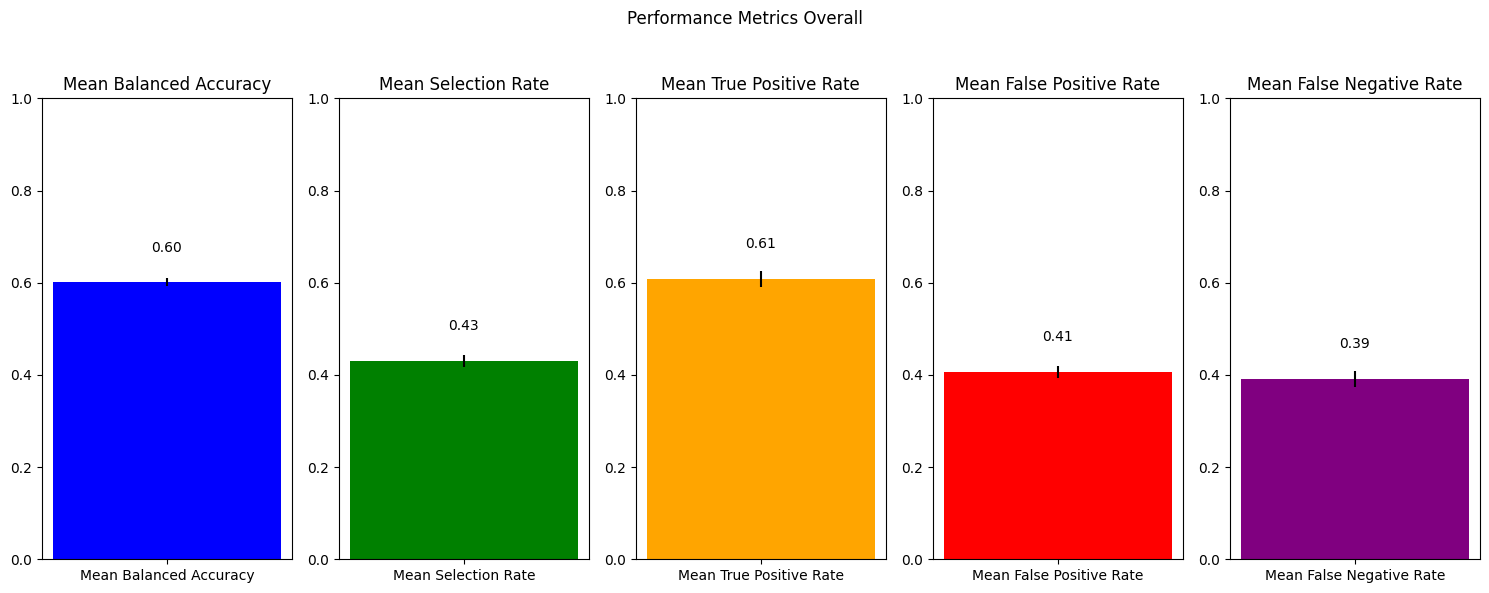

In [44]:
sums = [0] * 5
counts = [0] * 5
values_overall = [[] for _ in range(5)]

for i in range(len(value_overall)):
    group_index = i % 5
    sums[group_index] += value_overall[i]
    counts[group_index] += 1
    values_overall[group_index].append(value_overall[i])

averages = [sums[i] / counts[i] for i in range(5)]

std_devs = [np.std(values_overall[i]) for i in range(5)]

print("Averages:", averages)
print("Standard Deviations:", std_devs)

# # Corresponding labels
# labels = ['Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male']

# Colors for different metrics
colors = ['blue', 'green','orange', 'red','purple']

# Titles for different metric groups
titles = ['Mean Balanced Accuracy', 'Mean Selection Rate', 'Mean True Positive Rate', 'Mean False Positive Rate', 'Mean False Negative Rate' ]

# Create a bar plot
fig, ax_arr = plt.subplots(1, 5, figsize=(15, 6))

# Group data for each subplot
overall_averages = [averages[0], averages[1], averages[2], averages[3], averages[4]]
overall_std_devs = [std_devs[0], std_devs[1], std_devs[2], std_devs[3], std_devs[4]]
# grouped_labels = [labels[:2], labels[2:4], labels[4:6], labels[6:8], labels[8:]]
overall_colors = [colors[0], colors[1], colors[2], colors[3], colors[4]]

for i, ax in enumerate(ax_arr):
    # Plot bars
    bars = ax.bar( x=titles[i], height=overall_averages[i], yerr=overall_std_devs[i],  color=overall_colors[i])

    # Add labels to bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.06, f'{height:.2f}', ha='center', va='bottom')

    # Set the title for each subplot
    ax.set_title(titles[i])

    # Set the y-axis limit
    ax.set_ylim(0, 1)

# Add a main title for the entire figure
fig.suptitle('Performance Metrics Overall')

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Averages: [0.5915259638121746, 0.6196351263715626, 0.42692755823527256, 0.4375865231723092, 0.5896754721405095, 0.6460649265951744, 0.40662354451616045, 0.40679467385204904, 0.4103245278594905, 0.35393507340482555]
Standard Deviations: [0.010256957695816025, 0.012139137972674088, 0.015295363073535557, 0.015550626185563195, 0.02049444103533519, 0.022480964962279512, 0.016310683451643958, 0.01711601312116515, 0.020494441035335174, 0.022480964962279505]


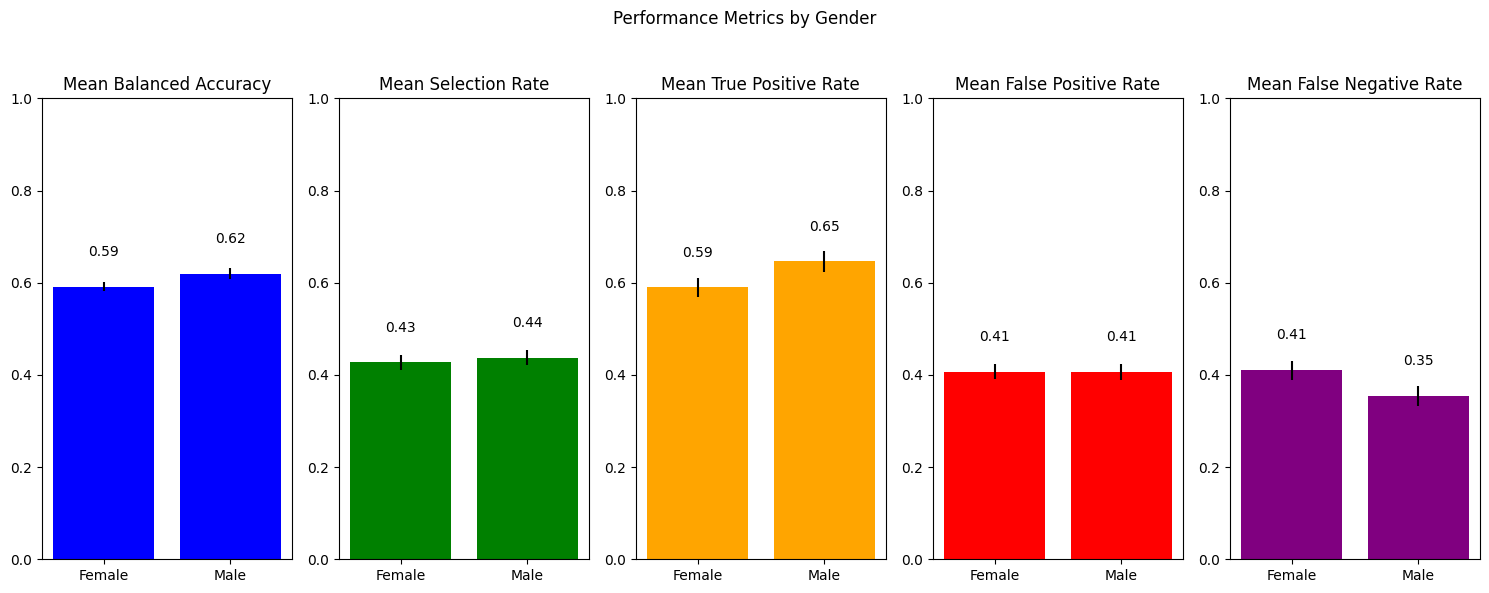

In [16]:
sums = [0] * 10
counts = [0] * 10
values_by_group = [[] for _ in range(10)]

for i in range(len(value)):
    group_index = i % 10
    sums[group_index] += value[i]
    counts[group_index] += 1
    values_by_group[group_index].append(value[i])

averages = [sums[i] / counts[i] for i in range(10)]

std_devs = [np.std(values_by_group[i]) for i in range(10)]

print("Averages:", averages)
print("Standard Deviations:", std_devs)

# Corresponding labels
labels = ['Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male']

# Colors for different metrics
colors = ['blue', 'blue', 'green', 'green', 'orange', 'orange', 'red', 'red', 'purple', 'purple']

# Titles for different metric groups
titles = ['Mean Balanced Accuracy', 'Mean Selection Rate', 'Mean True Positive Rate', 'Mean False Positive Rate', 'Mean False Negative Rate' ]

# Create a bar plot
fig, ax_arr = plt.subplots(1, 5, figsize=(15, 6))

# Group data for each subplot
grouped_averages = [averages[:2], averages[2:4], averages[4:6], averages[6:8], averages[8:]]
grouped_std_devs = [std_devs[:2], std_devs[2:4], std_devs[4:6], std_devs[6:8], std_devs[8:]]
grouped_labels = [labels[:2], labels[2:4], labels[4:6], labels[6:8], labels[8:]]
grouped_colors = [colors[:2], colors[2:4], colors[4:6], colors[6:8], colors[8:]]

for i, ax in enumerate(ax_arr):
    # Plot bars
    bars = ax.bar(grouped_labels[i], grouped_averages[i], yerr=grouped_std_devs[i],  color=grouped_colors[i])

    # Add labels to bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.06, f'{height:.2f}', ha='center', va='bottom')

    # Set the title for each subplot
    ax.set_title(titles[i])

    # Set the y-axis limit
    ax.set_ylim(0, 1)

# Add a main title for the entire figure
fig.suptitle('Performance Metrics by Gender')

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

###down

In [45]:
random_states = range(10)
value_down=[]
value_down_overall=[]

for rs in random_states:

    X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, A, test_size=0.2, random_state=rs, stratify=y)

    X_train_down, y_train_down, A_train_down = resample_training_data(X_train, y_train, A_train)

    df_train =  pd.concat([X_train_down, A_train_down], axis=1)
    df_train['target'] = y_train_down
    balanced_df2 = balance_classes_downsample(df_train, target='target', feature='CODE_GENDER', random_state=123)
    sensitive_features= 'CODE_GENDER'
    A_train_down = balanced_df2[sensitive_features]

    X_train_down = balanced_df2.drop(['target', 'CODE_GENDER'], axis=1)
    y_train_down = balanced_df2['target']

    pipeline_steps = [
    ('scaler', MinMaxScaler()),
    ('classifier', XGBClassifier())
    ]

    # Create the pipeline
    model_pipeline_downsample = Pipeline(steps=pipeline_steps)

    # Define the parameter grid
    param_grid_downsample = {
        'classifier__n_estimators': np.arange(20, 400, 20),
        'classifier__learning_rate': [0.01, 0.02, 0.05, 0.08, 0.1, 0.15, 0.2],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__max_depth': np.arange(3, 18, 1),
        'classifier__min_child_weight': np.arange(1, 8, 1),
        # 'classifier__eval_metric': ['auc']
    }

    # To let the random search to give the same result each time
    random_search_downsample = RandomizedSearchCV(model_pipeline_downsample, param_grid_downsample, scoring='balanced_accuracy', cv=5, random_state=234).fit(X_train_down, y_train_down)
    best_pipeline_downsample = random_search_downsample.best_estimator_

    y_test_pred_downsample = best_pipeline_downsample.predict(X_test)

    metricframe_unmitigated_downsample = MetricFrame(
      metrics=fairness_metrics,
      y_true=y_test,
      y_pred=y_test_pred_downsample,
      sensitive_features=A_test,
    )

    metricframe_unmitigated_downsample.overall[metrics_to_report]

    # ax_arr_downsample = metricframe_unmitigated_downsample.by_group[metrics_to_report].plot.bar(
    #     subplots=True, layout=[1, 3], figsize=[12, 4], legend=None, rot=0
    # )

    # for ax in ax_arr_downsample.flatten():
    #   for bar in ax.patches:
    #     value_down.append(bar.get_height())

    # Extract metric values by group and append to value list
    by_group_metrics = metricframe_unmitigated_downsample.by_group[metrics_to_report]
    for metric in metrics_to_report:
        for group_value in by_group_metrics[metric]:
            value_down.append(group_value)

    # Extract metric values overall and append to value list
    overall_metrics_down = metricframe_unmitigated_downsample.overall[metrics_to_report]
    for metric in metrics_to_report:
        overall_value_down = overall_metrics_down[metric]
        value_down_overall.append(overall_value_down)

# Print or use the collected values as needed
print("Collected metric values by group:", value_down)

Collected metric values by group: [0.5950689935064934, 0.6054028450272173, 0.4980487804878049, 0.4876873661670236, 0.6674107142857143, 0.6707317073170732, 0.4772727272727273, 0.4599260172626387, 0.3325892857142857, 0.32926829268292684, 0.588087058675294, 0.6207989713576305, 0.49890377588306944, 0.44981213097155126, 0.6561085972850679, 0.6587301587301587, 0.4799344799344799, 0.4171322160148976, 0.3438914027149321, 0.3412698412698413, 0.5569148936170213, 0.6259797676628087, 0.46308068459657703, 0.46112886048988283, 0.5638297872340425, 0.6830357142857143, 0.45, 0.43107617896009676, 0.43617021276595747, 0.3169642857142857, 0.5720507717509034, 0.6123617719377722, 0.4794921875, 0.468482905982906, 0.6073752711496746, 0.6652360515021459, 0.46327372764786795, 0.4405125076266016, 0.3926247288503254, 0.33476394849785407, 0.6089606307215402, 0.6230252431551133, 0.48746653687028474, 0.4760623991393222, 0.6814159292035398, 0.6900826446280992, 0.4634946677604594, 0.4440321583178726, 0.318584070796460

In [46]:
len(value_down_overall)

50

Averages: [0.6018124364098142, 0.47610589812332443, 0.6560518731988472, 0.45242700037921885, 0.3439481268011527]
Standard Deviations: [0.011144130875355079, 0.011169174383586139, 0.02481609391210415, 0.010857998738861077, 0.024816093912104157]


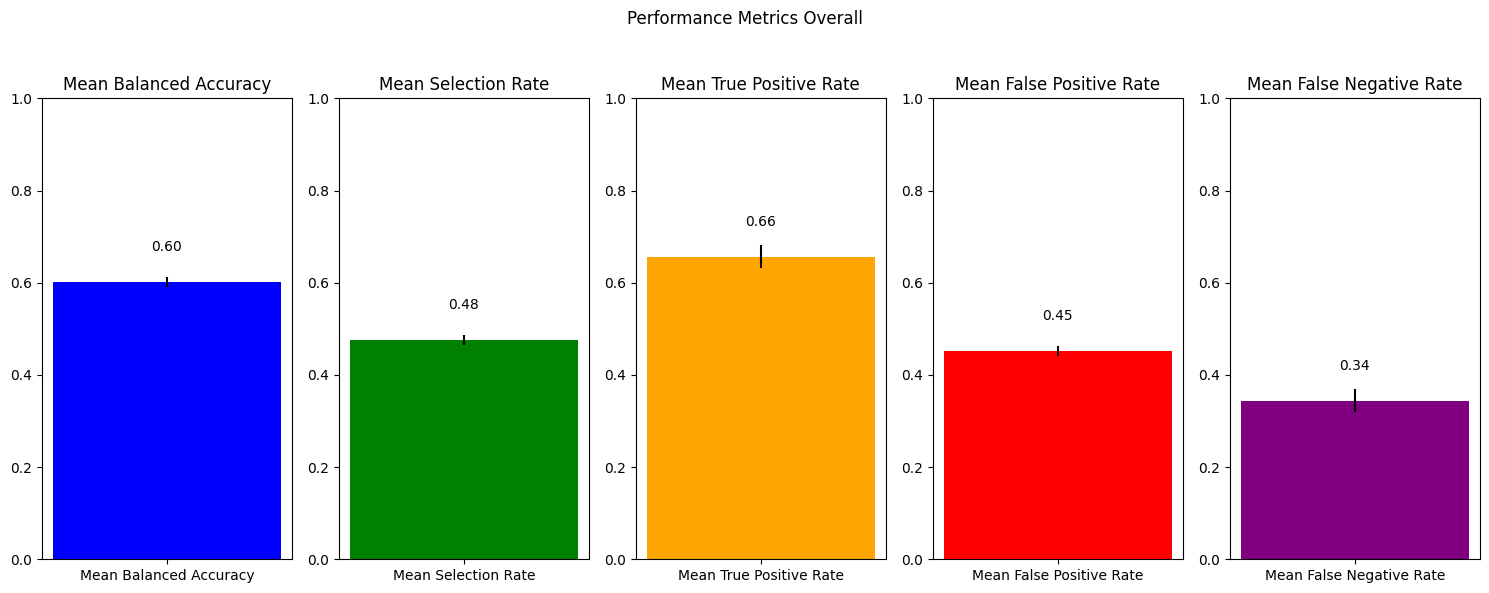

In [47]:
sums = [0] * 5
counts = [0] * 5
values_overall = [[] for _ in range(5)]

for i in range(len(value_down_overall)):
    group_index = i % 5
    sums[group_index] += value_down_overall[i]
    counts[group_index] += 1
    values_overall[group_index].append(value_down_overall[i])

averages = [sums[i] / counts[i] for i in range(5)]

std_devs = [np.std(values_overall[i]) for i in range(5)]

print("Averages:", averages)
print("Standard Deviations:", std_devs)

# # Corresponding labels
# labels = ['Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male']

# Colors for different metrics
colors = ['blue', 'green','orange', 'red','purple']

# Titles for different metric groups
titles = ['Mean Balanced Accuracy', 'Mean Selection Rate', 'Mean True Positive Rate', 'Mean False Positive Rate', 'Mean False Negative Rate' ]

# Create a bar plot
fig, ax_arr = plt.subplots(1, 5, figsize=(15, 6))

# Group data for each subplot
overall_averages = [averages[0], averages[1], averages[2], averages[3], averages[4]]
overall_std_devs = [std_devs[0], std_devs[1], std_devs[2], std_devs[3], std_devs[4]]
# grouped_labels = [labels[:2], labels[2:4], labels[4:6], labels[6:8], labels[8:]]
overall_colors = [colors[0], colors[1], colors[2], colors[3], colors[4]]

for i, ax in enumerate(ax_arr):
    # Plot bars
    bars = ax.bar( x=titles[i], height=overall_averages[i], yerr=overall_std_devs[i],  color=overall_colors[i])

    # Add labels to bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.06, f'{height:.2f}', ha='center', va='bottom')

    # Set the title for each subplot
    ax.set_title(titles[i])

    # Set the y-axis limit
    ax.set_ylim(0, 1)

# Add a main title for the entire figure
fig.suptitle('Performance Metrics Overall')

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Averages: [0.5920726121664481, 0.6222623723044713, 0.48075851227707994, 0.4658892923330448, 0.6445297416443083, 0.6790638479841324, 0.46038451731141194, 0.4345391033751899, 0.35547025835569174, 0.3209361520158676]
Standard Deviations: [0.015145381600046498, 0.010620100511379538, 0.012707559994577648, 0.014920548386687417, 0.033298706606441186, 0.023598737484591573, 0.012051720228338938, 0.015548579880441176, 0.033298706606441186, 0.02359873748459157]


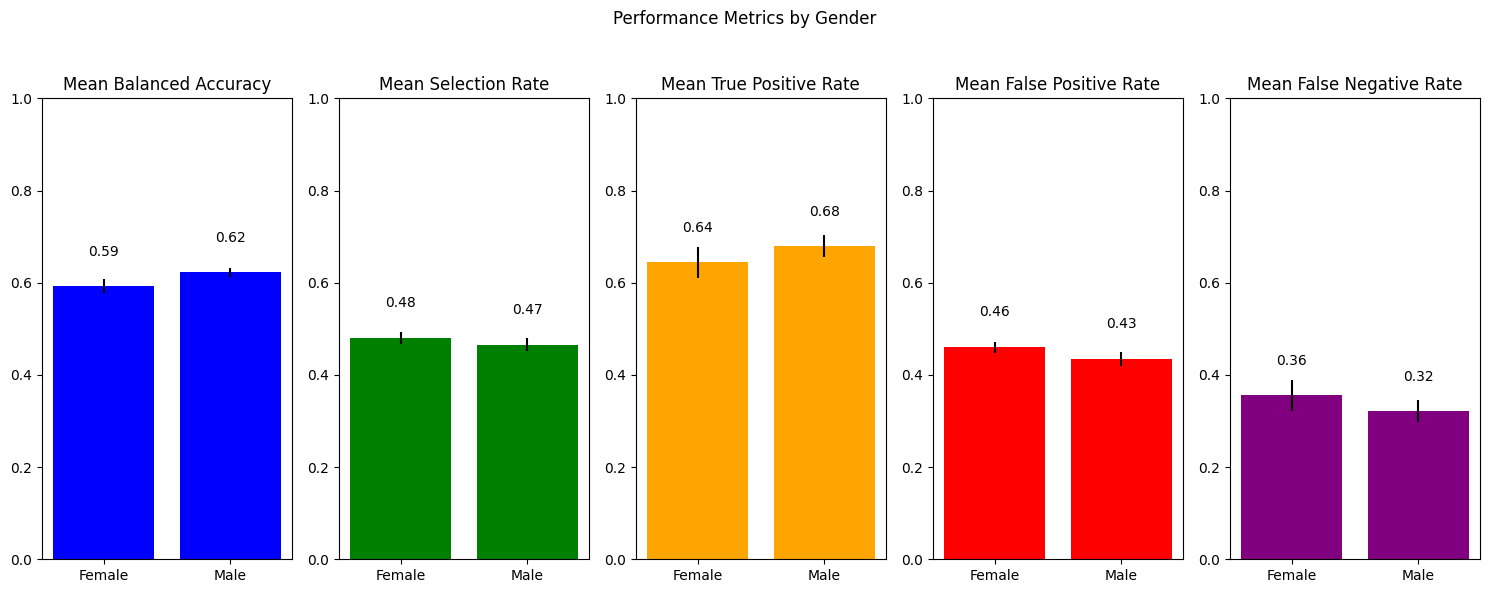

In [19]:
sums = [0] * 10
counts = [0] * 10
values_by_group = [[] for _ in range(10)]

for i in range(len(value_down)):
    group_index = i % 10
    sums[group_index] += value_down[i]
    counts[group_index] += 1
    values_by_group[group_index].append(value_down[i])

averages = [sums[i] / counts[i] for i in range(10)]

std_devs = [np.std(values_by_group[i]) for i in range(10)]

print("Averages:", averages)
print("Standard Deviations:", std_devs)

# Corresponding labels
labels = ['Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male']

# Colors for different metrics
colors = ['blue', 'blue', 'green', 'green', 'orange', 'orange', 'red', 'red', 'purple', 'purple']

# Titles for different metric groups
titles = ['Mean Balanced Accuracy', 'Mean Selection Rate', 'Mean True Positive Rate', 'Mean False Positive Rate', 'Mean False Negative Rate' ]

# Create a bar plot
fig, ax_arr = plt.subplots(1, 5, figsize=(15, 6))

# Group data for each subplot
grouped_averages = [averages[:2], averages[2:4], averages[4:6], averages[6:8], averages[8:]]
grouped_std_devs = [std_devs[:2], std_devs[2:4], std_devs[4:6], std_devs[6:8], std_devs[8:]]
grouped_labels = [labels[:2], labels[2:4], labels[4:6], labels[6:8], labels[8:]]
grouped_colors = [colors[:2], colors[2:4], colors[4:6], colors[6:8], colors[8:]]

for i, ax in enumerate(ax_arr):
    # Plot bars
    bars = ax.bar(grouped_labels[i], grouped_averages[i], yerr=grouped_std_devs[i],  color=grouped_colors[i])

    # Add labels to bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.06, f'{height:.2f}', ha='center', va='bottom')

    # Set the title for each subplot
    ax.set_title(titles[i])

    # Set the y-axis limit
    ax.set_ylim(0, 1)

# Add a main title for the entire figure
fig.suptitle('Performance Metrics by Gender')

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

##in and post

In [51]:
value_post = []
value_in = []
value_post_overall = []
value_in_overall = []

random_states = range(10)

for rs in random_states:

    X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, A, test_size=0.2, random_state=rs, stratify=y)

    X_train_down, y_train_down, A_train_down = resample_training_data(X_train, y_train, A_train)

    pipeline_steps = [
        ('scaler', MinMaxScaler()),
        ('classifier', XGBClassifier())
    ]

    # Create the pipeline
    model_pipeline_xgb = Pipeline(steps=pipeline_steps)

    # Define the parameter grid
    param_grid_xgb = {
        'classifier__n_estimators': np.arange(20, 400, 20),
        'classifier__learning_rate': [0.01, 0.02, 0.05, 0.08, 0.1, 0.15, 0.2],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__max_depth': np.arange(3, 18, 1),
        'classifier__min_child_weight': np.arange(1, 8, 1),
        # 'classifier__eval_metric': ['auc']
    }

    # To let the random search to give the same result each time
    random_search_xgb =RandomizedSearchCV(model_pipeline_xgb, param_grid_xgb, scoring='balanced_accuracy', cv=5, random_state=234).fit(X_train_down, y_train_down)
    best_pipeline_xgb = random_search_xgb.best_estimator_
    y_test_pred_xgb = best_pipeline_xgb.predict(X_test)


    #post
    postprocess_est = ThresholdOptimizer(
    estimator=best_pipeline_xgb,
    constraints="equalized_odds",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method="predict_proba",
    )

    metricframe_unmitigated_xgb = MetricFrame(
        metrics=fairness_metrics,
        y_true=y_test,
        y_pred=y_test_pred_xgb,
        sensitive_features=A_test,
    )

    postprocess_est.fit(X=X_train_down, y=y_train_down, sensitive_features=A_train_down)

    postprocess_pred = postprocess_est.predict(X_test, sensitive_features=A_test)

    postprocess_pred_proba = postprocess_est._pmf_predict(
        X_test, sensitive_features=A_test
    )

    def compare_metricframe_results(mframe_1, mframe_2, metrics, names):
        return pd.concat(
            [mframe_1.by_group[metrics], mframe_2.by_group[metrics]],
            keys=names,
            axis=1,
        )

    bal_acc_postprocess = balanced_accuracy_score(y_test, postprocess_pred)
    eq_odds_postprocess = equalized_odds_difference(
        y_test, postprocess_pred, sensitive_features=A_test
    )

    metricframe_postprocess = MetricFrame(
        metrics=fairness_metrics,
        y_true=y_test,
        y_pred=postprocess_pred,
        sensitive_features=A_test,
    )

    metricframe_postprocess.overall[metrics_to_report]

    metricframe_postprocess.difference()[metrics_to_report]

    compare_metricframe_results(
        metricframe_unmitigated_xgb,
        metricframe_postprocess,
        metrics=metrics_to_report,
        names=["Unmitigated", "PostProcess"],
    )
    
    # Extract metric values by group and append to value list
    by_group_metrics_post = metricframe_postprocess.by_group[metrics_to_report]
    for metric in metrics_to_report:
        for group_value in by_group_metrics_post[metric]:
            value_post.append(group_value)

    # Extract metric values overall and append to value list
    overall_metrics_post = metricframe_postprocess.overall[metrics_to_report]
    for metric in metrics_to_report:
        overall_value = overall_metrics_post[metric]
        value_post_overall.append(overall_value)

    #in
    balanced_accuracy_unmitigated = balanced_accuracy_score(y_test, y_test_pred_xgb)
    equalized_odds_unmitigated = equalized_odds_difference(
    y_test, y_test_pred_xgb, sensitive_features=A_test)

    def get_expgrad_models_per_epsilon(
        estimator, epsilon, X_train, y_train, A_train
    ):

        exp_grad_est = ExponentiatedGradient(
            estimator=estimator,
            sample_weight_name='classifier__sample_weight',
            constraints=EqualizedOdds(difference_bound=epsilon),
        )
        # Is this an issue - Re-runs
        exp_grad_est.fit(X_train, y_train, sensitive_features=A_train)
        predictors = exp_grad_est.predictors_
        return predictors

    epsilons = [ 0.01, 0.02, 0.05, 0.1]

    all_models = {}
    for eps in epsilons:
        all_models[eps] = get_expgrad_models_per_epsilon(
            estimator=best_pipeline_xgb,
            epsilon=eps,
            X_train=X_train_down,
            y_train=y_train_down,
            A_train=A_train_down,
        )

    def is_pareto_efficient(points):
        n, m = points.shape
        is_efficient = np.ones(n, dtype=bool)
        for i, c in enumerate(points):
            if is_efficient[i]:
                is_efficient[is_efficient] = np.any(
                    points[is_efficient] < c, axis=1
                )
                is_efficient[i] = True
        return is_efficient

    def filter_dominated_rows(points):
        pareto_mask = is_pareto_efficient(points.to_numpy())
        return pareto_mask, points.loc[pareto_mask, :]

    def aggregate_predictor_performances(
        predictors, metric, X_test, Y_test, A_test=None
    ):

        all_predictions = [predictor.predict(X_test) for predictor in predictors]
        if A_test is not None:
            return [
                metric(Y_test, Y_sweep, sensitive_features=A_test)
                for Y_sweep in all_predictions
            ]
        else:
            return [metric(Y_test, Y_sweep) for Y_sweep in all_predictions]

    def model_performance_sweep(models_dict, X_test, y_test, A_test):
        performances = []
        for (eps, models) in models_dict.items():
            eq_odds_difference = aggregate_predictor_performances(
                models, equalized_odds_difference, X_test, y_test, A_test
            )
            bal_acc_score = aggregate_predictor_performances(
                models, balanced_accuracy_score, X_test, y_test
            )
            for (i, score) in enumerate(eq_odds_difference):
                performances.append((eps, i, score, (1 - bal_acc_score[i])))
        performances_df = pd.DataFrame.from_records(
            performances,
            columns=["epsilon", "index", "equalized_odds", "balanced_error"],
        )
        return performances_df

    performance_df = model_performance_sweep(all_models, X_test, y_test, A_test)
    performance_subset = performance_df.loc[:, ["equalized_odds", "balanced_error"]]

    mask, pareto_subset = filter_dominated_rows(performance_subset)

    performance_df_masked = performance_df.loc[mask, :]



    def filter_models_by_unmitigiated_score(
        all_models,
        models_frames,
        unmitigated_score,
        performance_metric="balanced_error",
        fairness_metric="equalized_odds",
        threshold=0.01,
    ):

        # Create threshold based on balanced_error of unmitigated model and filter
        models_filtered = models_frames.query(
            f"{performance_metric} <= {unmitigated_score + threshold}"
        )
        if models_filtered.empty:
            raise ValueError("No models meet the performance threshold.")

        best_row = models_filtered.sort_values(by=[fairness_metric]).iloc[0]
        # Choose the model with smallest equalized_odds difference
        epsilon, index = best_row[["epsilon", "index"]]
        return {
            "model": all_models[epsilon][index],
            "epsilon": epsilon,
            "index": index,
        }

    best_model_E= filter_models_by_unmitigiated_score(
        all_models,
        models_frames=performance_df,
        unmitigated_score=(1.0 - balanced_accuracy_unmitigated),
        threshold=0.015,
    )


    inprocess_model = best_model_E.get("model")

    y_pred_inprocess = inprocess_model.predict(X_test)

    bal_acc_inprocess = balanced_accuracy_score(y_test, y_pred_inprocess)
    eq_odds_inprocess = equalized_odds_difference(
        y_test, y_pred_inprocess, sensitive_features=A_test
    )

    metricframe_inprocess = MetricFrame(
        metrics=fairness_metrics,
        y_true=y_test,
        y_pred=y_pred_inprocess,
        sensitive_features=A_test,
    )
    # Extract metric values overall and append to value list
    overall_metrics_in = metricframe_inprocess.overall[metrics_to_report]
    for metric in metrics_to_report:
        overall_value = overall_metrics_in[metric]
        value_in_overall.append(overall_value)

    # Extract metric values by group and append to value list
    by_group_metrics_in = metricframe_inprocess.by_group[metrics_to_report]
    for metric in metrics_to_report:
        for group_value in by_group_metrics_in[metric]:
            value_in.append(group_value)


c:\Users\liuxuemeng\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\postprocessing\_interpolated_thresholder.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 1. 1. ... 0. 0. 0.]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[
c:\Users\liuxuemeng\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\postprocessing\_interpolated_thresholder.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 1. 1. ... 0. 0. 0.]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[
c:\Users\liuxuemeng\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\postprocessing\_interp

##in

Averages: [0.6011835834319629, 0.46007037533512074, 0.6389048991354467, 0.4365377322715206, 0.3610951008645533]
Standard Deviations: [0.012322000635130899, 0.012742089382305014, 0.023502496632394575, 0.013478294870880099, 0.023502496632394555]


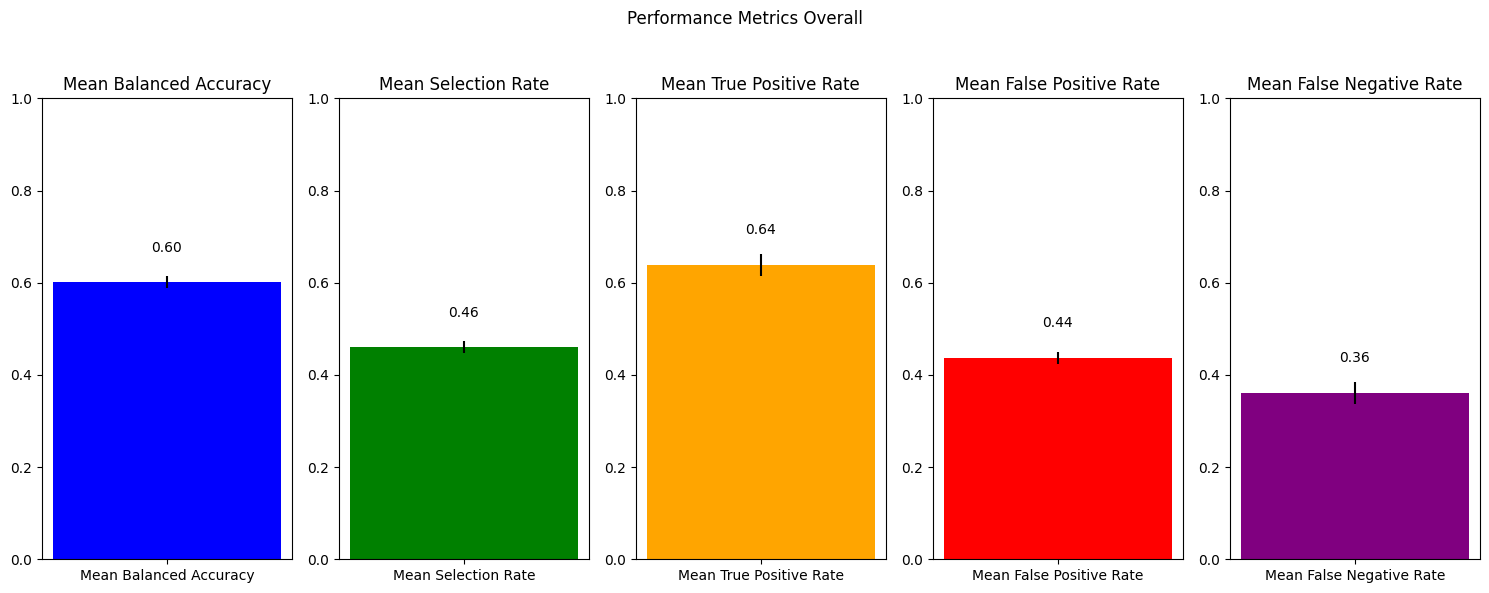

In [52]:
sums = [0] * 5
counts = [0] * 5
values_overall = [[] for _ in range(5)]

for i in range(len(value_in_overall)):
    group_index = i % 5
    sums[group_index] += value_in_overall[i]
    counts[group_index] += 1
    values_overall[group_index].append(value_in_overall[i])

averages = [sums[i] / counts[i] for i in range(5)]

std_devs = [np.std(values_overall[i]) for i in range(5)]

print("Averages:", averages)
print("Standard Deviations:", std_devs)

# # Corresponding labels
# labels = ['Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male']

# Colors for different metrics
colors = ['blue', 'green','orange', 'red','purple']

# Titles for different metric groups
titles = ['Mean Balanced Accuracy', 'Mean Selection Rate', 'Mean True Positive Rate', 'Mean False Positive Rate', 'Mean False Negative Rate' ]

# Create a bar plot
fig, ax_arr = plt.subplots(1, 5, figsize=(15, 6))

# Group data for each subplot
overall_averages = [averages[0], averages[1], averages[2], averages[3], averages[4]]
overall_std_devs = [std_devs[0], std_devs[1], std_devs[2], std_devs[3], std_devs[4]]
# grouped_labels = [labels[:2], labels[2:4], labels[4:6], labels[6:8], labels[8:]]
overall_colors = [colors[0], colors[1], colors[2], colors[3], colors[4]]

for i, ax in enumerate(ax_arr):
    # Plot bars
    bars = ax.bar( x=titles[i], height=overall_averages[i], yerr=overall_std_devs[i],  color=overall_colors[i])

    # Add labels to bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.06, f'{height:.2f}', ha='center', va='bottom')

    # Set the title for each subplot
    ax.set_title(titles[i])

    # Set the y-axis limit
    ax.set_ylim(0, 1)

# Add a main title for the entire figure
fig.suptitle('Performance Metrics Overall')

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Averages: [0.6023866313870169, 0.5983394616604911, 0.45621281367669014, 0.46866768136534204, 0.638314769930407, 0.6400886697699806, 0.4335415071563732, 0.4434097464489987, 0.361685230069593, 0.3599113302300194]
Standard Deviations: [0.013870600866372153, 0.009810853613169959, 0.014404311047259038, 0.01625905084551638, 0.024298837163712707, 0.025154622273256565, 0.01566364027070664, 0.015690255930845422, 0.024298837163712693, 0.025154622273256568]


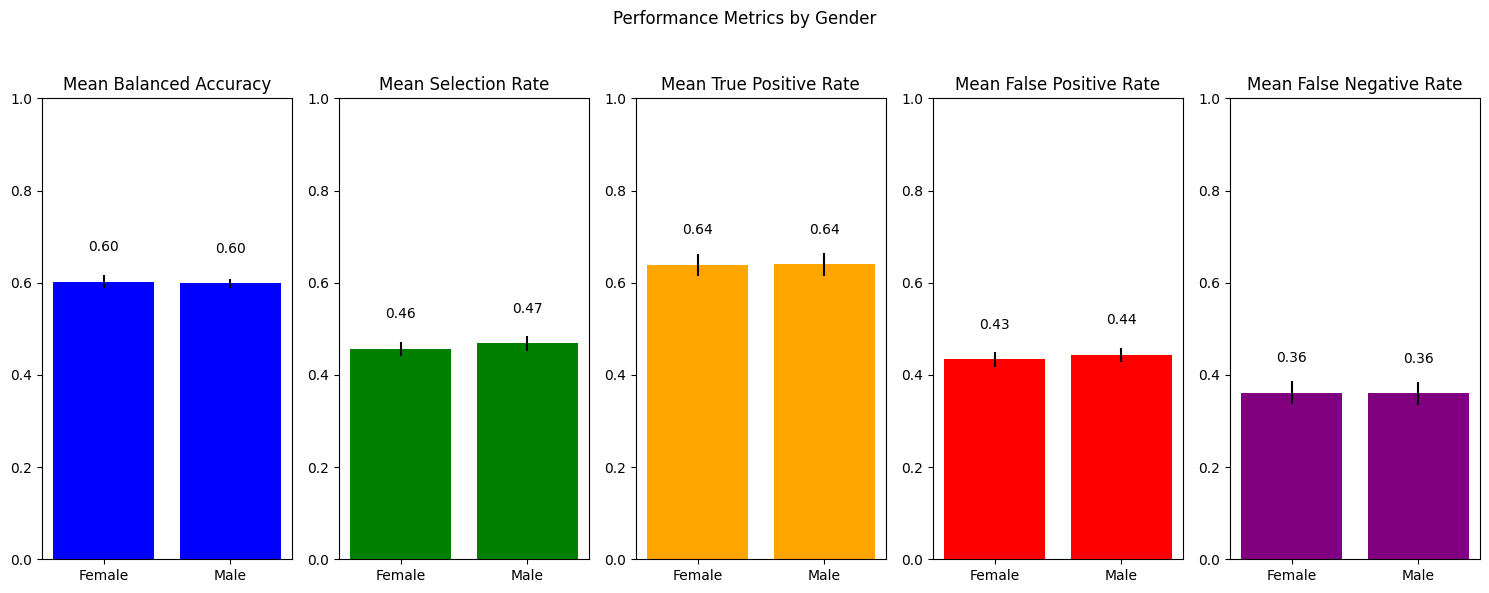

In [21]:
sums = [0] * 10
counts = [0] * 10
values_by_group = [[] for _ in range(10)]

for i in range(len(value_in)):
    group_index = i % 10
    sums[group_index] += value_in[i]
    counts[group_index] += 1
    values_by_group[group_index].append(value_in[i])

averages = [sums[i] / counts[i] for i in range(10)]

std_devs = [np.std(values_by_group[i]) for i in range(10)]

print("Averages:", averages)
print("Standard Deviations:", std_devs)

# Corresponding labels
labels = ['Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male']

# Colors for different metrics
colors = ['blue', 'blue', 'green', 'green', 'orange', 'orange', 'red', 'red', 'purple', 'purple']

# Titles for different metric groups
titles = ['Mean Balanced Accuracy', 'Mean Selection Rate', 'Mean True Positive Rate', 'Mean False Positive Rate', 'Mean False Negative Rate' ]

# Create a bar plot
fig, ax_arr = plt.subplots(1, 5, figsize=(15, 6))

# Group data for each subplot
grouped_averages = [averages[:2], averages[2:4], averages[4:6], averages[6:8], averages[8:]]
grouped_std_devs = [std_devs[:2], std_devs[2:4], std_devs[4:6], std_devs[6:8], std_devs[8:]]
grouped_labels = [labels[:2], labels[2:4], labels[4:6], labels[6:8], labels[8:]]
grouped_colors = [colors[:2], colors[2:4], colors[4:6], colors[6:8], colors[8:]]

for i, ax in enumerate(ax_arr):
    # Plot bars
    bars = ax.bar(grouped_labels[i], grouped_averages[i], yerr=grouped_std_devs[i],  color=grouped_colors[i])

    # Add labels to bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.06, f'{height:.2f}', ha='center', va='bottom')

    # Set the title for each subplot
    ax.set_title(titles[i])

    # Set the y-axis limit
    ax.set_ylim(0, 1)

# Add a main title for the entire figure
fig.suptitle('Performance Metrics by Gender')

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Post

Averages: [0.5950153490725532, 0.42731233243967826, 0.5952449567723344, 0.4052142586272279, 0.40475504322766576]
Standard Deviations: [0.01586769911110682, 0.03709210293708634, 0.03905111811897176, 0.03838374878394697, 0.03905111811897176]


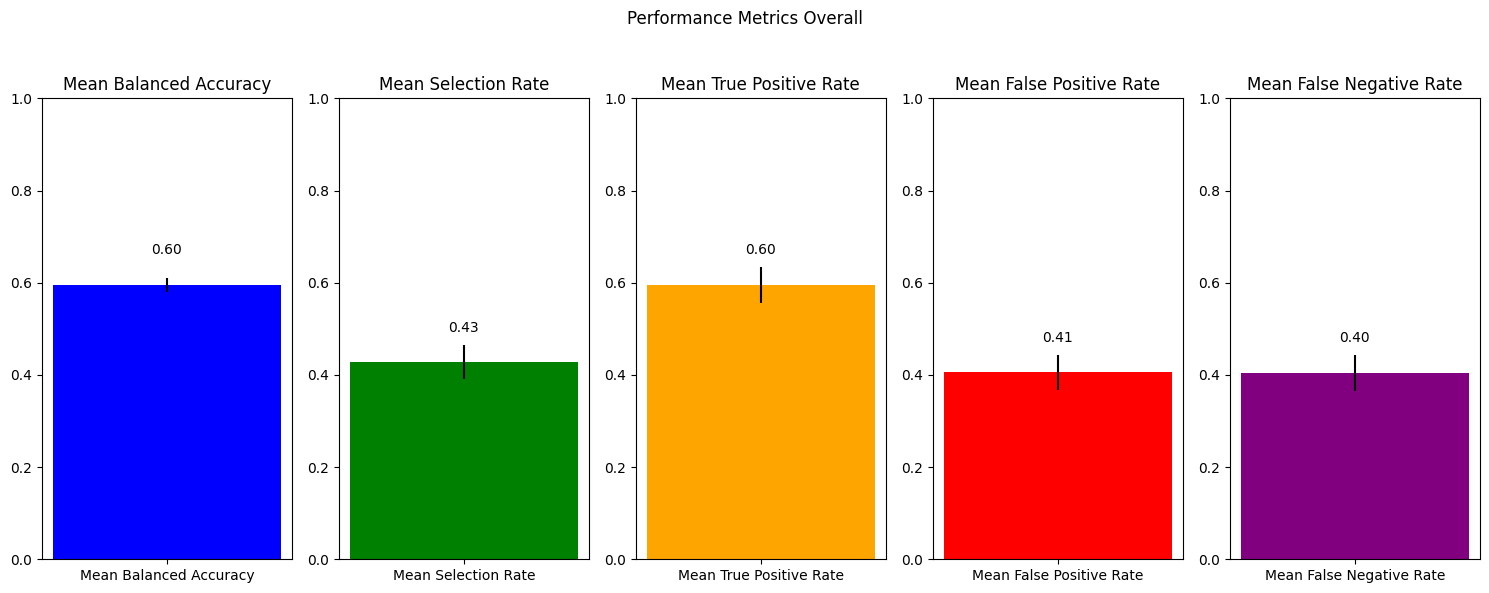

In [50]:
sums = [0] * 5
counts = [0] * 5
values_overall = [[] for _ in range(5)]

for i in range(len(value_post_overall)):
    group_index = i % 5
    sums[group_index] += value_post_overall[i]
    counts[group_index] += 1
    values_overall[group_index].append(value_post_overall[i])

averages = [sums[i] / counts[i] for i in range(5)]

std_devs = [np.std(values_overall[i]) for i in range(5)]

print("Averages:", averages)
print("Standard Deviations:", std_devs)

# # Corresponding labels
# labels = ['Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male']

# Colors for different metrics
colors = ['blue', 'green','orange', 'red','purple']

# Titles for different metric groups
titles = ['Mean Balanced Accuracy', 'Mean Selection Rate', 'Mean True Positive Rate', 'Mean False Positive Rate', 'Mean False Negative Rate' ]

# Create a bar plot
fig, ax_arr = plt.subplots(1, 5, figsize=(15, 6))

# Group data for each subplot
overall_averages = [averages[0], averages[1], averages[2], averages[3], averages[4]]
overall_std_devs = [std_devs[0], std_devs[1], std_devs[2], std_devs[3], std_devs[4]]
# grouped_labels = [labels[:2], labels[2:4], labels[4:6], labels[6:8], labels[8:]]
overall_colors = [colors[0], colors[1], colors[2], colors[3], colors[4]]

for i, ax in enumerate(ax_arr):
    # Plot bars
    bars = ax.bar( x=titles[i], height=overall_averages[i], yerr=overall_std_devs[i],  color=overall_colors[i])

    # Add labels to bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.06, f'{height:.2f}', ha='center', va='bottom')

    # Set the title for each subplot
    ax.set_title(titles[i])

    # Set the y-axis limit
    ax.set_ylim(0, 1)

# Add a main title for the entire figure
fig.suptitle('Performance Metrics Overall')

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Averages: [0.5957789201492101, 0.5930970917452945, 0.42284316872819794, 0.4373018001580443, 0.5932001207714992, 0.5996366691265376, 0.4016422804730791, 0.41344248563594854, 0.4067998792285009, 0.40036333087346254]
Standard Deviations: [0.016522078664061746, 0.017999149491988796, 0.04197266354846873, 0.030886566437598784, 0.04149416312366892, 0.04075538895386375, 0.04332634564554206, 0.0319188873715932, 0.04149416312366892, 0.040755388953863755]


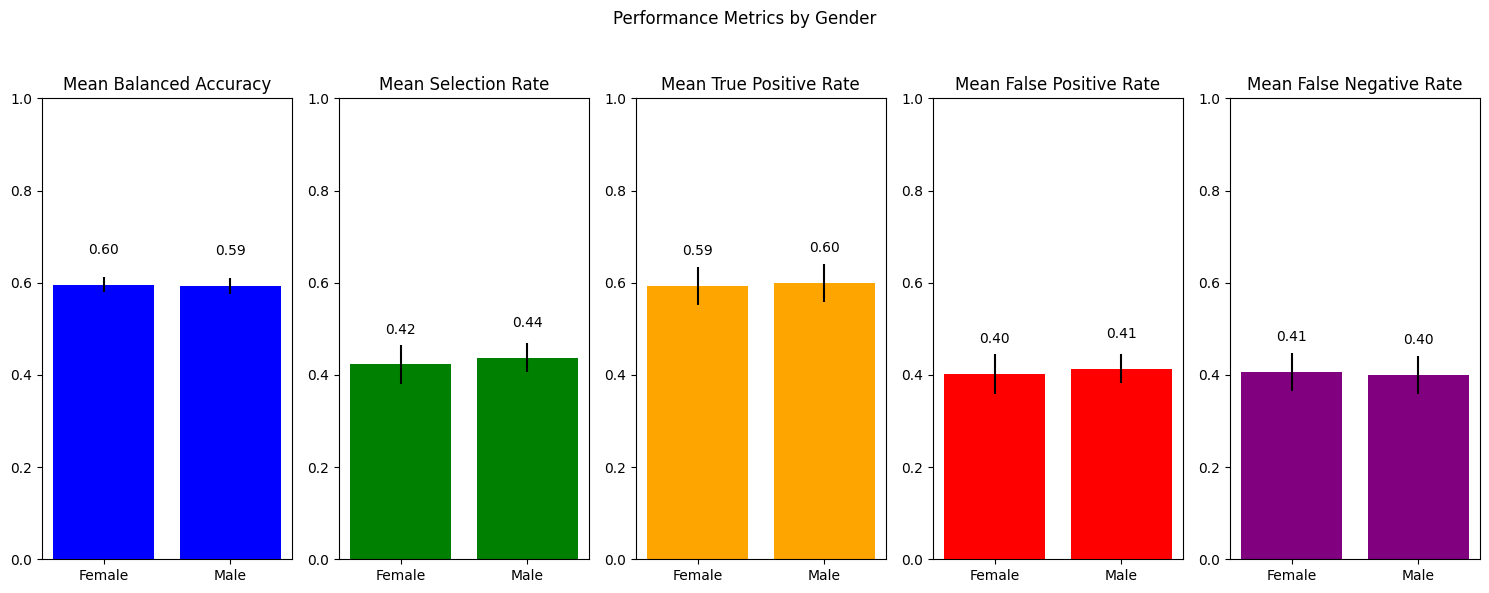

In [22]:
sums = [0] * 10
counts = [0] * 10
values_by_group = [[] for _ in range(10)]

for i in range(len(value_post)):
    group_index = i % 10
    sums[group_index] += value_post[i]
    counts[group_index] += 1
    values_by_group[group_index].append(value_post[i])

averages = [sums[i] / counts[i] for i in range(10)]

std_devs = [np.std(values_by_group[i]) for i in range(10)]

print("Averages:", averages)
print("Standard Deviations:", std_devs)

# Corresponding labels
labels = ['Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male']

# Colors for different metrics
colors = ['blue', 'blue', 'green', 'green', 'orange', 'orange', 'red', 'red', 'purple', 'purple']

# Titles for different metric groups
titles = ['Mean Balanced Accuracy', 'Mean Selection Rate', 'Mean True Positive Rate', 'Mean False Positive Rate', 'Mean False Negative Rate' ]

# Create a bar plot
fig, ax_arr = plt.subplots(1, 5, figsize=(15, 6))

# Group data for each subplot
grouped_averages = [averages[:2], averages[2:4], averages[4:6], averages[6:8], averages[8:]]
grouped_std_devs = [std_devs[:2], std_devs[2:4], std_devs[4:6], std_devs[6:8], std_devs[8:]]
grouped_labels = [labels[:2], labels[2:4], labels[4:6], labels[6:8], labels[8:]]
grouped_colors = [colors[:2], colors[2:4], colors[4:6], colors[6:8], colors[8:]]

for i, ax in enumerate(ax_arr):
    # Plot bars
    bars = ax.bar(grouped_labels[i], grouped_averages[i], yerr=grouped_std_devs[i],  color=grouped_colors[i])

    # Add labels to bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.06, f'{height:.2f}', ha='center', va='bottom')

    # Set the title for each subplot
    ax.set_title(titles[i])

    # Set the y-axis limit
    ax.set_ylim(0, 1)

# Add a main title for the entire figure
fig.suptitle('Performance Metrics by Gender')

# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Visualization

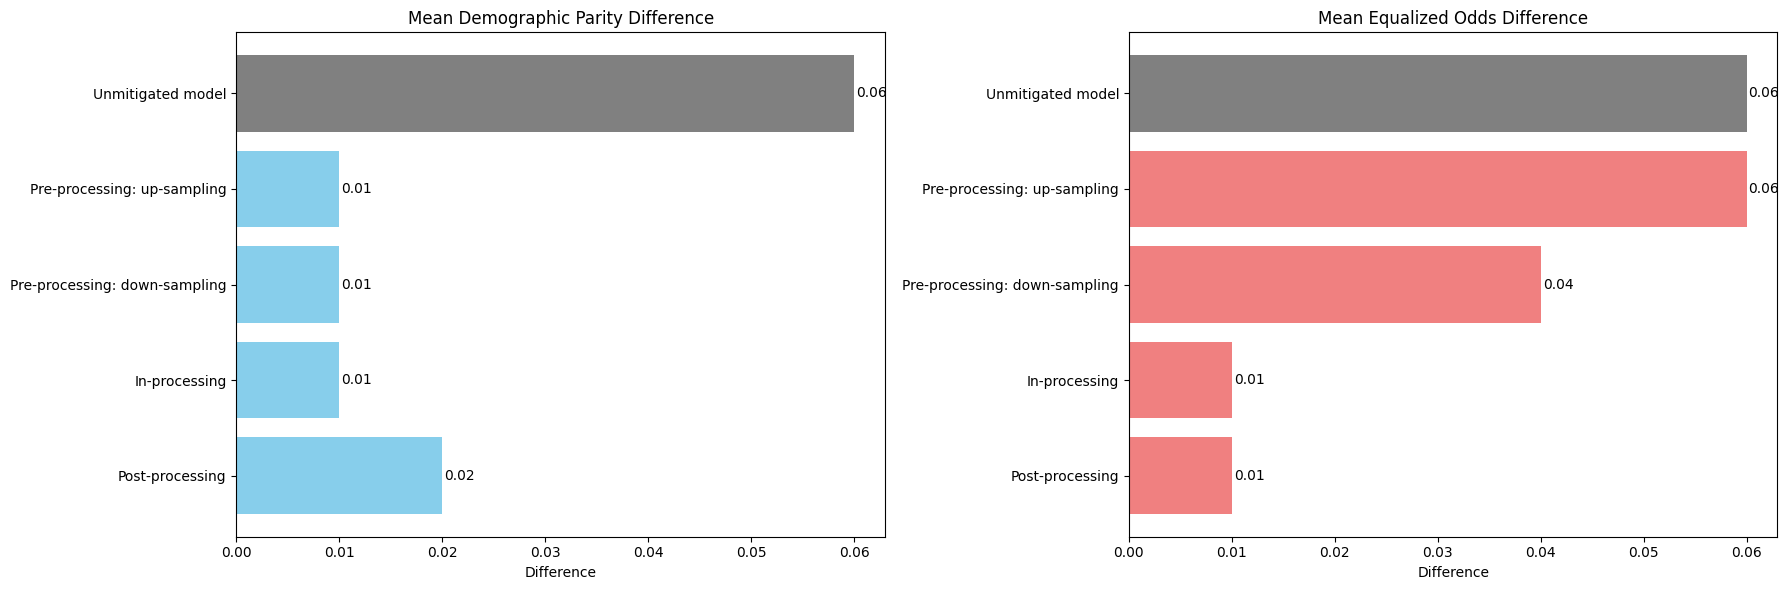

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
methods = ['Unmitigated model', 'Pre-processing: up-sampling', 'Pre-processing: down-sampling', 'In-processing', 'Post-processing']
dp_diff = [0.06, 0.01, 0.01, 0.01, 0.02]
eo_diff = [0.06, 0.06, 0.04, 0.01, 0.01]

# Function to create bar charts side by side
def create_side_by_side_bar_charts(dp_data, eo_data, labels, dp_title, eo_title, ylabel, dp_color, eo_color, unmitigated_color='gray'):
    fig, ax_arr = plt.subplots(1, 2, figsize=(18, 6))
    
    # Create color lists with different color for "Unmitigated model"
    dp_colors = [unmitigated_color if label == 'Unmitigated model' else dp_color for label in labels]
    eo_colors = [unmitigated_color if label == 'Unmitigated model' else eo_color for label in labels]
    
    # Plot the first bar chart
    y_pos = np.arange(len(labels))
    bars_dp = ax_arr[0].barh(y_pos, dp_data, color=dp_colors)
    ax_arr[0].set_yticks(y_pos)
    ax_arr[0].set_yticklabels(labels)
    ax_arr[0].invert_yaxis()  # labels read top-to-bottom
    ax_arr[0].set_xlabel(ylabel)
    ax_arr[0].set_title(dp_title)

    # Add text labels to the bars
    for bar in bars_dp:
        width = bar.get_width()
        label_y_pos = bar.get_y() + bar.get_height() / 2
        ax_arr[0].text(width + 0.0002, label_y_pos, f'{width:.2f}', va='center')

    # Plot the second bar chart
    bars_eo = ax_arr[1].barh(y_pos, eo_data, color=eo_colors)
    ax_arr[1].set_yticks(y_pos)
    ax_arr[1].set_yticklabels(labels)
    ax_arr[1].invert_yaxis()  # labels read top-to-bottom
    ax_arr[1].set_xlabel(ylabel)
    ax_arr[1].set_title(eo_title)

    # Add text labels to the bars
    for bar in bars_eo:
        width = bar.get_width()
        label_y_pos = bar.get_y() + bar.get_height() / 2
        ax_arr[1].text(width + 0.0002, label_y_pos, f'{width:.2f}', va='center')

    plt.tight_layout()
    plt.savefig('side_by_side_charts.png')
    plt.show()

# Create the side-by-side bar charts
create_side_by_side_bar_charts(dp_diff, eo_diff, methods, 
                               'Mean Demographic Parity Difference', 'Mean Equalized Odds Difference', 
                               'Difference', 'skyblue', 'lightcoral', unmitigated_color='gray')
